In [1]:
import pandas as pd
import numpy as npsadsadasdsa
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')
# warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
import sys
sys.path.append('../code')
import dataframe_utilities as util

In [4]:
import category_encoders as ce
import xgboost as xgb
from sklearn.metrics import roc_auc_score, accuracy_score

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from hyperopt import fmin, tpe, hp, Trials
from functools import partial

import seaborn as sns

# Get Data

In [5]:
df = pd.read_csv('../data/df_w_features.csv', low_memory=False)
df.shape

(935, 592)

In [6]:
X = df.drop(columns=['home_team_win', 'game_id', 'home_team_abbr', 'away_team_abbr', 'home_pitcher', 'away_pitcher', 'home_team_abbr', 'home_team_season', 'away_team_season'])
y = df.home_team_win

In [7]:
mask = pd.to_datetime(X['date'],unit='ns')>=pd.to_datetime('20-08-2019') #last time model was run
new_len = mask.sum() + 300 #add 300 more records to include old validation data, but none of the training data
X.drop(columns=['date'], inplace=True)
X_train = X[:-new_len]
y_train = y[:-new_len]
X_valid = X[-new_len:]
y_valid = y[-new_len:]

# Benchmark

In [8]:
import pickle
encoder, model = pickle.load(open('../data/encoder_model.pk','rb'))
encoder, model

FileNotFoundError: [Errno 2] No such file or directory: '../data/encoder_model.pk'

In [58]:
X_train = encoder.fit_transform(X_train, y_train)
X_valid = encoder.transform(X_valid)

NameError: name 'encoder' is not defined

In [ ]:
xgb_test_preds = model.predict(X_valid)
xgb_test_proba = model.predict_proba(X_valid)[:,1]

bench_acc = accuracy_score(y_valid, xgb_test_preds)
bench_roc = roc_auc_score(y_valid, xgb_test_preds)
print(f"benchmarks:\n- Accuracy: {bench_acc*100:.1f}%\n- ROC AUC: {bench_roc:.3f}")

benchmarks:
- Accuracy: 64.6%
- ROC AUC: 0.637


# XGB

## Tune

In [8]:
! pip install "ray[tune]==2.2.0"
! pip install "hyperopt"
! pip install "bayesian-optimization
! pip install "tensorflow>=2.9.0"

In [38]:
from ray import tune
from ray.tune.suggest.bayesopt import BayesOptSearch
from ray.tune.schedulers import ASHAScheduler
from ray.tune.schedulers import PopulationBasedTraining
from xgboost.callback import TrainingCallback
from xgboost import DMatrix
class XGBCallback(TrainingCallback):
    def __init__(self, X_valid, y_valid):
        super().__init__()
        self.X_valid = X_valid
        self.y_valid = y_valid
        self.dvalid = DMatrix(data=self.X_valid, label=self.y_valid)  # Convert to DMatrix once

    def after_iteration(self, model, epoch, evals_log):
        metrics = {}
        if evals_log:
            for dataset_name, dataset_metrics in evals_log.items():
                for metric_name, metric_values in dataset_metrics.items():
                    if metric_values:
                        last_item = metric_values[-1]
                        if isinstance(last_item, (list, tuple)) and len(last_item) > 1:
                            metrics[f"{dataset_name}_{metric_name}"] = last_item[1]
                        elif isinstance(last_item, (int, float)):
                            metrics[f"{dataset_name}_{metric_name}"] = last_item

        # Calculate ROC AUC score on validation set using DMatrix
        preds = model.predict(self.dvalid)
        roc_auc = roc_auc_score(self.y_valid, preds)
        metrics['mean_accuracy'] = roc_auc

        if metrics:
            tune.report(**metrics)
        return False  # Continue training

In [39]:
def train_xgb(params):
    for i in range(10):
        params['max_depth'] = int(params['max_depth'])
        gbm = xgb.XGBClassifier(**params, num_boost_round=100, random_state=13, n_jobs=-1)
        model = gbm.fit(X_train, y_train,
                        verbose=False,
                        eval_set = [[X_train, y_train],
                                  [X_valid, y_valid]],
                        early_stopping_rounds=15,
                        callbacks=[XGBCallback(X_valid, y_valid)])
        xgb_test_preds = model.predict(X_valid)
        proba = model.predict_proba(X_valid)[:,1]

        #penalize low discrimination
        score = roc_auc_score(y_valid, xgb_test_preds)
        if max(proba)<.7 and min(proba)>.3: score -= 0.05

        tune.report(mean_accuracy=score)

! pip install --upgrade ray


In [20]:
! pip install --upgrade ray
! pip install --upgrade ray[tune]

In [11]:
from ray import init
init(ignore_reinit_error=True)

2024-05-30 22:30:44,006	INFO worker.py:1538 -- Started a local Ray instance.


Python version:,3.9.0
Ray version:,2.2.0


In [45]:
import os
results_dir = "../ray_results/train_xgb"
os.makedirs(results_dir, exist_ok=True)

num_threads = 6
config = {
    "verbosity": 0,
    "num_threads": num_threads,
    "objective": "binary:logistic",
    "eval_metric": ["auc", "logloss"],
}

from ray.tune.schedulers import ASHAScheduler
space = {
    "max_depth": (10, 20),
    "min_child_weight": (2, 10),
    "learning_rate": (0.01,0.1),
    "subsample":(0.1,1),
    "colsample_bytree":(0.1,1),
    "reg_alpha": (1e-2, 1e2),
    "gamma": (1e-8, 1.0),
}

algo = BayesOptSearch(
    space,
    metric="mean_accuracy",
    mode="max",
    utility_kwargs={
            "kind": "ucb",
            "kappa": 2.5,
            "xi": 0.0,
        },
)
scheduler = ASHAScheduler(
    metric="mean_accuracy",  # Ensure this matches what `train_xgb` reports
    mode="max"  # This should match the goal of your optimization (maximizing or minimizing)
)
results = tune.run(
    train_xgb,
    resources_per_trial={"cpu": 1},  # Adjust based on your environment
    num_samples=500,
    search_alg=algo,
    scheduler=scheduler,
    local_dir=results_dir
)

Trial name,date,done,episodes_total,experiment_id,hostname,iterations_since_restore,mean_accuracy,node_ip,pid,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,validation_0_logloss,validation_1_logloss,warmup_time
train_xgb_00e64b48,2024-05-31_11-42-05,True,,93aa2e330d6642319123207b0ff8a509,DESKTOP-8C63R6S,16,0.5,127.0.0.1,9132,1.821,0.0429883,1.821,1717126925,0,,16,00e64b48,0.6917962067709195,0.6990008624394735,0.0109985
train_xgb_014fb3c7,2024-05-31_11-40-29,True,,401f3e4f171b4872b98a5cc79de76119,DESKTOP-8C63R6S,64,0.5,127.0.0.1,3236,10.225,0.0460019,10.225,1717126829,0,,64,014fb3c7,0.6917962067709195,0.6990008624394735,0.00900173
train_xgb_0222d68a,2024-05-31_11-49-23,True,,93aa2e330d6642319123207b0ff8a509,DESKTOP-8C63R6S,1,0.5,127.0.0.1,9132,0.496114,0.496114,0.496114,1717127363,0,,1,0222d68a,0.6917962067709195,0.6990008624394735,0.0109985
train_xgb_0238a257,2024-05-31_11-48-40,True,,93aa2e330d6642319123207b0ff8a509,DESKTOP-8C63R6S,4,0.526353,127.0.0.1,9132,9.05769,0.318999,9.05769,1717127320,0,,4,0238a257,0.6863879574565437,0.6983179662624995,0.0109985
train_xgb_02393e20,2024-05-31_11-39-19,True,,e032965732a947e9821773f53d0c719e,DESKTOP-8C63R6S,16,0.45,127.0.0.1,4360,31.8233,0.395005,31.8233,1717126759,0,,16,02393e20,,,0.00700235
train_xgb_0266a371,2024-05-31_11-39-43,True,,e032965732a947e9821773f53d0c719e,DESKTOP-8C63R6S,16,0.45,127.0.0.1,4360,1.493,0.302987,1.493,1717126783,0,,16,0266a371,,,0.00700235
train_xgb_03397220,2024-05-31_11-39-58,True,,93aa2e330d6642319123207b0ff8a509,DESKTOP-8C63R6S,16,0.45,127.0.0.1,9132,3.26301,0.311006,3.26301,1717126798,0,,16,03397220,,,0.0109985
train_xgb_036adb09,2024-05-31_11-39-19,True,,87d6ab287f974b5aa8ff68dce3d428b7,DESKTOP-8C63R6S,16,0.45,127.0.0.1,9524,21.5444,0.332998,21.5444,1717126759,0,,16,036adb09,,,0.00700283
train_xgb_04109a23,2024-05-31_11-42-48,True,,465eb672c87c49e5a647b7f5007f051d,DESKTOP-8C63R6S,64,0.550244,127.0.0.1,1464,25.754,0.0420103,25.754,1717126968,0,,64,04109a23,0.6837275698429017,0.699202599922816,0.00700402
train_xgb_05b5fa89,2024-05-31_11-49-04,True,,e67b3c198d2e4235a650d63cf6a2d67e,DESKTOP-8C63R6S,1,0.463056,127.0.0.1,26980,0.558993,0.558993,0.558993,1717127344,0,,1,05b5fa89,0.6902590692512632,0.6995601975917816,0.0129972


2024-05-31 11:51:48,489	INFO tune.py:762 -- Total run time: 795.30 seconds (794.47 seconds for the tuning loop).


In [57]:
from ray.tune import ExperimentAnalysis

# Assuming your results are stored in the '~/ray_results/train_xgb' directory
results_dir = "E:\Jiu Studios\SBAI Project\MLB\\ray_results\\train_xgb"
os.makedirs(results_dir, exist_ok=True)
# Load the results
analysis = ExperimentAnalysis(results_dir)

# Convert results to a DataFrame
df = analysis.dataframe()

# Display the DataFrame
print(df.head())

# Access specific metrics
max_mean_accuracy = df['mean_accuracy'].max()
print(f"Maximum Mean Accuracy: {max_mean_accuracy}")

# Access best hyperparameters
best_trial = analysis.get_best_trial('mean_accuracy', mode='max', scope='all')
best_config = best_trial.config
print(f"Best Hyperparameters: {best_config}")

2024-05-31 12:20:31,251	INFO experiment_analysis.py:795 -- No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.


   validation_0_logloss  validation_1_logloss  mean_accuracy  \
0              0.691796              0.699001       0.500000   
1              0.691796              0.699001       0.500000   
2              0.691796              0.699001       0.500000   
3              0.686388              0.698318       0.526353   
4                   NaN                   NaN       0.450000   

   time_this_iter_s  done  timesteps_total  episodes_total  \
0          0.042988  True              NaN             NaN   
1          0.046002  True              NaN             NaN   
2          0.496114  True              NaN             NaN   
3          0.318999  True              NaN             NaN   
4          0.395005  True              NaN             NaN   

   training_iteration  trial_id                     experiment_id  ...  \
0                  16  00e64b48  93aa2e330d6642319123207b0ff8a509  ...   
1                  64  014fb3c7  401f3e4f171b4872b98a5cc79de76119  ...   
2                   

## Greedy Hyperopt

,is_night_game,home_trueskill_pre,away_trueskill_pre,ts_diff,home_team_rest,away_team_rest,home_pitcher_rest,away_pitcher_rest,team_rest_diff,pitcher_rest_diff,...,pitcher_pitches_diff,pitcher_re24_def_diff,pitcher_strikes_contact_diff,pitcher_strikes_looking_diff,pitcher_strikes_swinging_diff,pitcher_strikes_total_diff,pitcher_wpa_def_diff,pitcher_SO_batters_faced_diff,pitcher_H_batters_faced_diff,pitcher_BB_batters_faced_diff
681,True,18.787875,29.924237,-11.136362,1,1,1,1,0,0,...,5.000000,NaN,NaN,1.200000,2.400000,0.500000,NaN,-0.031494,-0.086255,0.098030
682,True,26.970435,21.247916,5.722519,1,1,1,1,0,0,...,-82.428571,NaN,NaN,-10.142857,-5.428571,-51.000000,NaN,0.235714,-0.123810,-0.047619
683,True,22.972023,22.726255,0.245768,1,1,1,1,0,0,...,8.500000,NaN,NaN,3.000000,-0.500000,6.000000,NaN,-0.166667,0.500000,0.000000
684,True,22.670076,36.375928,-13.705852,1,1,1,1,0,0,...,-4.500000,NaN,NaN,-1.500000,3.000000,-2.500000,NaN,0.314286,-0.257143,0.071429
685,True,11.460079,34.238199,-22.778120,1,1,1,1,0,0,...,34.000000,NaN,NaN,7.666667,6.000000,26.333333,NaN,-0.053335,0.206971,0.040598
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
976,True,2.632843,22.781176,-20.148333,3,2,1,1,1,0,...,-35.166667,NaN,NaN,-9.166667,-3.333333,-19.166667,NaN,0.029151,0.066392,0.006410
977,True,17.769791,30.616462,-12.846671,30,30,30,30,0,0,...,-69.166667,NaN,NaN,-13.000000,-2.166667,-45.500000,NaN,0.145370,0.093519,-0.007407
978,True,32.009877,22.801961,9.207915,30,30,30,30,0,0,...,-2.375000,NaN,NaN,0.000000,0.000000,-1.000000,NaN,0.023810,0.000000,0.000000
979,True,9.995011,22.251200,-12.256189,30,30,21,21,0,0,...,-2.375000,NaN,NaN,0.000000,0.000000,-1.000000,NaN,0.023810,0.000000,0.000000


In [90]:
X_train['date']

0      1970-01-01 00:00:01.709251200
1      1970-01-01 00:00:01.709251200
2      1970-01-01 00:00:01.709251200
3      1970-01-01 00:00:01.709251200
4      1970-01-01 00:00:01.709251200
                   ...              
676    1970-01-01 00:00:01.713312000
677    1970-01-01 00:00:01.713312000
678    1970-01-01 00:00:01.713312000
679    1970-01-01 00:00:01.713312000
680    1970-01-01 00:00:01.713312000
Name: date, Length: 681, dtype: object

In [58]:
xgb_params = best_config

In [59]:
xgb_params

{'colsample_bytree': 0.46139512619485423,
 'gamma': 0.4027212386656252,
 'learning_rate': 0.04024215974348862,
 'max_depth': 17.14903792698944,
 'min_child_weight': 5.500842222830271,
 'reg_alpha': 12.567357691257456,
 'subsample': 0.6336354741576095}

In [63]:
import numpy as np
def xgb_objective(new_params, data):
    X_train,y_train,X_valid,y_valid, params = data
    
    if 'max_depth' in new_params.keys():
        new_params['max_depth']=int(new_params['max_depth'])
    if 'reg_alpha' in new_params.keys():
        new_params['reg_alpha']=np.exp(new_params['reg_alpha'])
    
    for x in new_params.keys():
        params[x] = new_params[x]
    
    np.random.seed(13)
    gbm = xgb.XGBClassifier(**params, num_boost_round=100, random_state=13, n_jobs=-1)
    model = gbm.fit(X_train, y_train,
                    verbose=False,
                    eval_set = [[X_train, y_train],
                              [X_valid, y_valid]],
                    early_stopping_rounds=15)
    xgb_test_preds = model.predict(X_valid)
    proba = model.predict_proba(X_valid)[:,1]
    
    #penalize low discrimination
    score = -roc_auc_score(y_valid, xgb_test_preds)
    if max(proba)<.7 and min(proba)>.3: score += 0.05
    
    return(score)

In [64]:
def get_xgbparams(space, full_params, evals=15):
    fmin_objective = partial(xgb_objective, data=(X_train,y_train,X_valid,y_valid,full_params))
    
    params = fmin(fmin_objective,
        space=space,
        algo=tpe.suggest,
        max_evals=evals)
    
    #update full_params
    for x in full_params.keys():
        if x in params.keys():
            full_params[x]=params[x]
    full_params['max_depth']=int(full_params['max_depth'])
    if 'reg_alpha' in params.keys():
        full_params['reg_alpha']=np.exp(params['reg_alpha'])
    
    return full_params

In [65]:
space = {
    'max_depth':  hp.quniform('max_depth', 10, 20, 1),
    'min_child_weight': hp.quniform('min_child_weight', 2, 10, 1),
    'learning_rate': hp.quniform('learning_rate', .01, .08, .01),
    'subsample': hp.quniform('subsample', 0.1, 1, 0.1),
    'colsample_bytree': hp.quniform('colsample_bytree', 0.1, 1, 0.1),
    'reg_alpha': hp.quniform('reg_alpha', -2, 4,0.5),
}
xgb_params = get_xgbparams(space,xgb_params,10)

100%|██████████| 10/10 [00:11<00:00,  1.18s/trial, best loss: -0.5096928037257624]


In [66]:
xgb_params

{'colsample_bytree': 1.0,
 'gamma': 0.4027212386656252,
 'learning_rate': 0.02,
 'max_depth': 11,
 'min_child_weight': 5.0,
 'reg_alpha': 1.6487212707001282,
 'subsample': 0.5}

## Test

In [67]:
xgb_params

{'colsample_bytree': 1.0,
 'gamma': 0.4027212386656252,
 'learning_rate': 0.02,
 'max_depth': 11,
 'min_child_weight': 5.0,
 'reg_alpha': 1.6487212707001282,
 'subsample': 0.5}

In [68]:
gbm = xgb.XGBClassifier(**xgb_params, num_boost_round=100, random_state=13, n_jobs=-1)
model = gbm.fit(X_train, y_train,
                verbose=True,
                eval_set = [[X_train, y_train],
                          [X_valid, y_valid]],
                early_stopping_rounds=15)
xgb_test_preds = model.predict(X_valid)
xgb_test_proba = model.predict_proba(X_valid)[:,1]
accuracy_score(y_valid, xgb_test_preds), roc_auc_score(y_valid, xgb_test_preds)

[0]	validation_0-logloss:0.69016	validation_1-logloss:0.69980
[1]	validation_0-logloss:0.68809	validation_1-logloss:0.69909
[2]	validation_0-logloss:0.68584	validation_1-logloss:0.69838
[3]	validation_0-logloss:0.68399	validation_1-logloss:0.69810
[4]	validation_0-logloss:0.68229	validation_1-logloss:0.69843
[5]	validation_0-logloss:0.67962	validation_1-logloss:0.69836
[6]	validation_0-logloss:0.67745	validation_1-logloss:0.69839
[7]	validation_0-logloss:0.67528	validation_1-logloss:0.69877
[8]	validation_0-logloss:0.67336	validation_1-logloss:0.69932
[9]	validation_0-logloss:0.67144	validation_1-logloss:0.69999
[10]	validation_0-logloss:0.66967	validation_1-logloss:0.69850
[11]	validation_0-logloss:0.66757	validation_1-logloss:0.69823
[12]	validation_0-logloss:0.66600	validation_1-logloss:0.69880
[13]	validation_0-logloss:0.66368	validation_1-logloss:0.69876
[14]	validation_0-logloss:0.66151	validation_1-logloss:0.69841
[15]	validation_0-logloss:0.65961	validation_1-logloss:0.69818
[1

(0.55, 0.5596928037257625)

In [69]:
print(f"new model ROC: {roc_auc_score(y_valid, xgb_test_preds):.3f}")

new model ROC: 0.560


In [70]:
model.save_model('team_wins_model.json')

In [71]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from hyperopt import fmin, tpe, hp, STATUS_OK
df = pd.read_csv('../data/df_w_features_score.csv', low_memory=False)
df.shape
X = df.drop(columns=['total_runs', 'game_id', 'home_team_abbr_x', 'away_team_abbr', 'home_pitcher', 'away_pitcher', 'home_team_abbr_y', 'home_team_season', 'away_team_season'])
y = df.total_runs
mask = pd.to_datetime(X['date'],unit='ns')>=pd.to_datetime('20-08-2019') #last time model was run
new_len = mask.sum() + 300 #add 300 more records to include old validation data, but none of the training data
X.drop('date', axis=1, inplace=True)
X_train = X[:-new_len]
y_train = y[:-new_len]
X_valid = X[-new_len:]
y_valid = y[-new_len:]


xgb_params = {'colsample_bytree': 1.0,
 'gamma': 1e-08,
 'learning_rate': 0.1,
 'max_depth': 10,
 'min_child_weight': 10.0,
 'reg_alpha': 25.2379554214079,
 'subsample': 0.10694933059531121}


def xgb_objective(new_params, data):
    X_train,y_train,X_valid,y_valid, params = data
    
    if 'max_depth' in new_params.keys():
        new_params['max_depth']=int(new_params['max_depth'])
    if 'reg_alpha' in new_params.keys():
        new_params['reg_alpha']=np.exp(new_params['reg_alpha'])
    
    for x in new_params.keys():
        params[x] = new_params[x]
    
    np.random.seed(13)
    gbm = xgb.XGBRegressor(**params, num_boost_round=100, random_state=13, n_jobs=-1)
    model = gbm.fit(X_train, y_train,
                    verbose=False,
                    eval_set = [[X_train, y_train],
                              [X_valid, y_valid]],
                    early_stopping_rounds=15)
    xgb_test_preds = model.predict(X_valid)
    rmse = np.sqrt(mean_squared_error(y_valid, xgb_test_preds))
    return {'loss': rmse, 'status': STATUS_OK}
def get_xgbparams(space, full_params, evals=15):
    fmin_objective = partial(xgb_objective, data=(X_train, y_train, X_valid, y_valid, full_params))
    
    best = fmin(fmin_objective,
                space=space,
                algo=tpe.suggest,
                max_evals=evals)
    
    # Update the full_params with the best parameters found
    for key, value in best.items():
        if key in ['max_depth', 'min_child_weight']:
            full_params[key] = int(value)
        else:
            full_params[key] = value
    
    return full_params


space = {
    'max_depth': hp.quniform('max_depth', 10, 20, 1),
    'min_child_weight': hp.quniform('min_child_weight', 2, 10, 1),
    'learning_rate': hp.quniform('learning_rate', .01, .08, .01),
    'subsample': hp.quniform('subsample', 0.1, 1, 0.1),
    'colsample_bytree': hp.quniform('colsample_bytree', 0.1, 1, 0.1),
    'reg_alpha': hp.quniform('reg_alpha', 0, 4, 0.5),  # Adjusted range to [0, 4]
}
xgb_params = get_xgbparams(space,xgb_params,10)


gbm = xgb.XGBRegressor(**xgb_params, num_boost_round=100, random_state=13, n_jobs=-1)
model = gbm.fit(X_train, y_train,
                verbose=True,
                eval_set = [[X_train, y_train],
                          [X_valid, y_valid]],
                early_stopping_rounds=15)
xgb_test_preds = model.predict(X_valid)
rmse = np.sqrt(mean_squared_error(y_valid, xgb_test_preds))
mae = mean_absolute_error(y_valid, xgb_test_preds)

print(f"RMSE: {rmse:.3f}")
print(f"MAE: {mae:.3f}")


model.save_model('total_score_model.json')

100%|██████████| 10/10 [00:15<00:00,  1.51s/trial, best loss: 4.617591671312462]
[0]	validation_0-rmse:4.79869	validation_1-rmse:4.66364
[1]	validation_0-rmse:4.67334	validation_1-rmse:4.64331
[2]	validation_0-rmse:4.55871	validation_1-rmse:4.65051
[3]	validation_0-rmse:4.44584	validation_1-rmse:4.64604
[4]	validation_0-rmse:4.33160	validation_1-rmse:4.65329
[5]	validation_0-rmse:4.21568	validation_1-rmse:4.65817
[6]	validation_0-rmse:4.10912	validation_1-rmse:4.64685
[7]	validation_0-rmse:4.00277	validation_1-rmse:4.62375
[8]	validation_0-rmse:3.90159	validation_1-rmse:4.61531
[9]	validation_0-rmse:3.80980	validation_1-rmse:4.61355
[10]	validation_0-rmse:3.71571	validation_1-rmse:4.62879
[11]	validation_0-rmse:3.62880	validation_1-rmse:4.63942
[12]	validation_0-rmse:3.54341	validation_1-rmse:4.63606
[13]	validation_0-rmse:3.43949	validation_1-rmse:4.65570
[14]	validation_0-rmse:3.35669	validation_1-rmse:4.66329
[15]	validation_0-rmse:3.26990	validation_1-rmse:4.65261
[16]	validation_0

## EDA

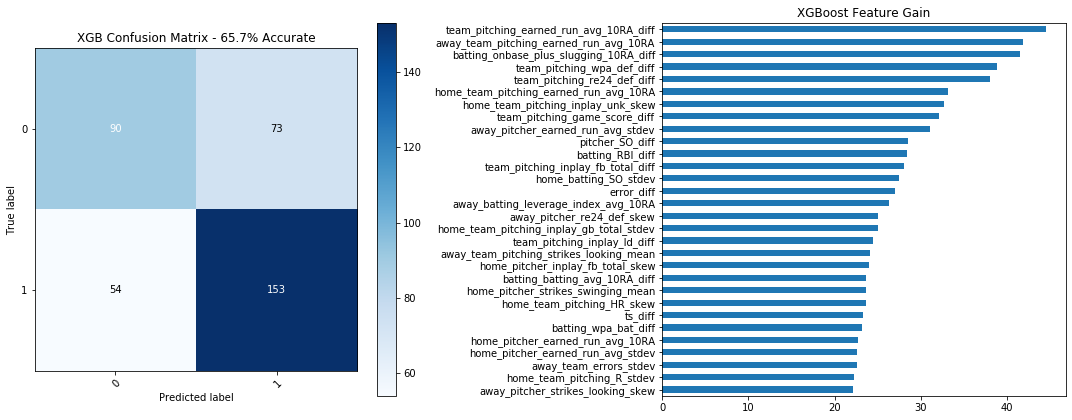

In [22]:
fig, ax = plt.subplots(1,2,figsize=(15,6))

x = pd.Series(model.get_booster().get_score(importance_type= 'total_gain')
         ).sort_values()
x[-30:].plot(kind='barh',ax=ax[1], title="XGBoost Feature Gain")

util.plot_confusion_matrix(y_valid, xgb_test_preds, [0,1], 
                           ax=ax[0], title = f"XGB Confusion Matrix - {accuracy_score(y_valid, xgb_test_preds)*100:.1f}% Accurate")

fig.tight_layout()

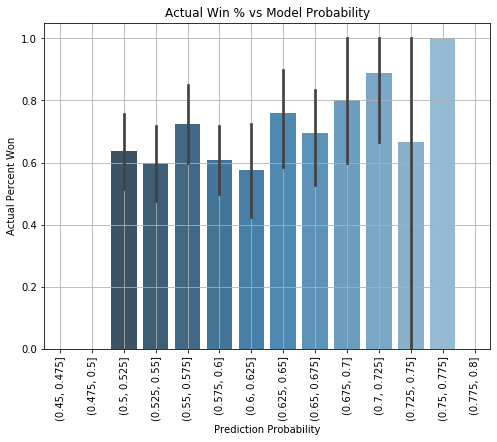

In [28]:
df = pd.DataFrame()
df['proba'] = xgb_test_proba
df['home_win'] = list(y_valid)
df['confidence'] = np.abs(df.proba-.5)+.5
df['bet_win'] = df['home_win']
df['bet_win'][df['proba']<.5] = -df['home_win']

bins=[x/40 for x in range(18,33)]
df['probability_bin'] = pd.cut(df['confidence'], bins)

plt.figure(figsize=(8,6))
ax = sns.barplot(x=df['probability_bin'], y=df.bet_win,palette="Blues_d")
ax.set_title("Actual Win % vs Model Probability")
plt.ylabel("Actual Percent Won")
plt.xlabel("Prediction Probability")
ax.grid()
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

# df.groupby('probability_bin')['bet_win'].agg(['mean','count'])

In [30]:
print("win % for bets with greater than x confidence:")
for x in range(10,18):
    d = df.bet_win[df.confidence>=x/20]
    print(f" conf: {x/20:.2f}, win %:{d.mean()*100:.1f}%, % of total {d.count()*100/len(df):.1f}%")

win % for bets with greater than x confidence:
 conf: 0.50, win %:65.7%, % of total 100.0%
 conf: 0.55, win %:67.9%, % of total 64.1%
 conf: 0.60, win %:69.9%, % of total 35.9%
 conf: 0.65, win %:75.0%, % of total 17.3%
 conf: 0.70, win %:84.6%, % of total 3.5%
 conf: 0.75, win %:100.0%, % of total 0.3%
 conf: 0.80, win %:nan%, % of total 0.0%
 conf: 0.85, win %:nan%, % of total 0.0%


In [ ]:
df = pd.read_csv('../data/df_w_features_score.csv', low_memory=False)
df.shape
X = df.drop(columns=['total_runs', 'game_id'])
y = df.total_runs
mask = pd.to_datetime(X['date'],unit='s')>=pd.to_datetime('20-08-2019') #last time model was run
new_len = mask.sum() + 300 #add 300 more records to include old validation data, but none of the training data

X_train = X[:-new_len]
y_train = y[:-new_len]
X_valid = X[-new_len:]
y_valid = y[-new_len:]

X_train = encoder.fit_transform(X_train, y_train)
X_valid = encoder.transform(X_valid)

# Other Models

## LightGBM

In [ ]:
import lightgbm as lgbm

In [ ]:
lgbm_params = {'colsample_by_tree': 0.7,
 'learning_rate': 0.65,
 'max_depth': 8,
 'min_data_in_leaf': 500,
 'num_leaves': 204,
 'subsample': 0.6,
 'boosting_type': 'gbdt'}

In [ ]:
gbm = lgbm.LGBMClassifier(**lgbm_params,num_boost_round=100, random_state=-1)
model = gbm.fit(X_train, y_train,
                verbose=False,
                eval_set = [[X_train, y_train],
                          [X_valid, y_valid]],
                early_stopping_rounds=15)
lgbm_test_preds = model.predict(X_valid)
lgbm_test_proba = model.predict_proba(X_valid)[:,1]
accuracy_score(y_valid, lgbm_test_preds), roc_auc_score(y_valid, lgbm_test_preds)

In [ ]:
def lgbm_objective(new_params, data):
    X_train,y_train,X_valid,y_valid, params = data
    
    if 'max_depth' in new_params.keys():
        new_params['max_depth']=int(new_params['max_depth'])
        params['num_leaves']=int(2**params['max_depth']*params['num_leaves'])
    if 'min_data_in_leaf' in new_params.keys():
        params['min_data_in_leaf']=int(params['min_data_in_leaf'])
    
    for x in new_params.keys():
        params[x] = new_params[x]
    
    np.random.seed(13)
    gbm = lgbm.LGBMClassifier(**params, num_boost_round=100, random_state=13)
    lgbm_model = gbm.fit(X_train, y_train,
                    verbose=False,
                    eval_set = [[X_train, y_train],
                              [X_valid, y_valid]],
                    early_stopping_rounds=15)
    lgbm_test_preds = lgbm_model.predict(X_valid)
    
    proba = lgbm_model.predict_proba(X_valid)[:,1]
    
    #penalize low discrimination
    score = -roc_auc_score(y_valid, lgbm_test_preds)
    if max(proba)<.7 and min(proba)>.3: score += 0.05
    
    return score 
def get_lgbmparams(space, full_params, evals=15):
    fmin_objective = partial(xgb_objective, data=(X_train,y_train,X_valid,y_valid,full_params))
    
    params = fmin(fmin_objective,
        space=space,
        algo=tpe.suggest,
        max_evals=evals)
    
    #update full_params
    for x in full_params.keys():
        if x in params.keys():
            full_params[x]=params[x]
    full_params['max_depth']=int(full_params['max_depth'])
    full_params['min_data_in_leaf']=int(full_params['min_data_in_leaf'])
    full_params['num_leaves']=int(2**full_params['max_depth']*full_params['num_leaves'])

    return full_params

In [ ]:
space = {
    'learning_rate': hp.quniform('learning_rate', .05, .8, .05),
    'max_depth': hp.quniform('max_depth', 2, 10, 1),
    'num_leaves': hp.quniform('num_leaves', 0.5, 1.0,.1),
#     'subsample': hp.quniform('subsample', 0.05, 1, .05),
#     'colsample_bytree': hp.quniform('colsample_by_tree', 0.05, 1.0,.05),
#     'min_data_in_leaf':hp.qloguniform('min_data_in_leaf', 5, 10, 100),
}
lgbm_params = get_lgbmparams(space,lgbm_params,25)

In [ ]:
space = {
#     'learning_rate': hp.quniform('learning_rate', .05, .8, .05),
#     'max_depth': hp.quniform('max_depth', 2, 10, 1),
#     'num_leaves': hp.quniform('num_leaves', 0.5, 1.0,.1),
    'subsample': hp.quniform('subsample', 0.1, 1, .1),
    'colsample_bytree': hp.quniform('colsample_by_tree', 0.1, 1.0,.1),
    'min_data_in_leaf':hp.qloguniform('min_data_in_leaf', 5, 10, 100),
}
lgbm_params = get_lgbmparams(space,lgbm_params,25)

In [ ]:
lgbm_params

In [ ]:
np.random.seed(13)
gbm = lgbm.LGBMClassifier(**lgbm_params, num_boost_round=100, random_state=13)
lgbm_model = gbm.fit(X_train, y_train,
                verbose=True,
                eval_set = [[X_train, y_train],
                          [X_valid, y_valid]],
                early_stopping_rounds=15)
lgbm_test_preds = lgbm_model.predict(X_valid)
lgbm_test_proba = lgbm_model.predict_proba(X_valid)[:,1]
accuracy_score(y_valid, lgbm_test_preds), roc_auc_score(y_valid, lgbm_test_preds)

In [ ]:
print(f"new model ROC: {roc_auc_score(y_valid, lgbm_test_preds):.3f}\nold model ROC: {bench_roc:.3f}\n")

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(15,6))

lgbm_model.importance_type='gain'
l = pd.DataFrame(zip(X_train.columns,lgbm_model.feature_importances_), 
                 columns=['feature','value']).set_index('feature').sort_values(by='value')
l[-30:].plot(kind='barh',ax=ax[1],title="LightGBM Feature Gain")

util.plot_confusion_matrix(y_valid, lgbm_test_preds, [0,1], ax=ax[0],
                           title = f"LGBM Confusion Matrix - {accuracy_score(y_valid, lgbm_test_preds)*100:.1f}% Accurate")

fig.tight_layout()

In [ ]:
df = pd.DataFrame()
df['proba'] = lgbm_test_proba
df['home_win'] = list(y_valid)
df['confidence'] = np.abs(df.proba-.5)+.5
df['bet_win'] = df['home_win']
df['bet_win'][df['proba']<.5] = -df['home_win']

bins=[x/40 for x in range(19,30)]
df['probability_bin'] = pd.cut(df['confidence'], bins)

plt.figure(figsize=(8,6))
ax = sns.barplot(x=df['probability_bin'], y=df.bet_win,palette="Blues_d")
ax.set_title("Actual Win % vs Model Probability")
plt.ylabel("Actual Percent Won")
plt.xlabel("Prediction Probability")
ax.grid()
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

# df.groupby('probability_bin')['bet_win'].agg(['mean','count'])

In [ ]:
print("win % for bets with greater than x confidence:")
for x in range(10,19):
    d = df.bet_win[df.confidence>x/20]
    print(f" conf: {x/20:.2f}, win %:{d.mean()*100:.1f}%, % of total {d.count()/6:.1f}%")

## Fastai

In [ ]:
from fastai import *
from fastai.tabular import *

In [ ]:
CAT_NAMES = [x for x in df.columns if df[x].dtype=='object']
CONT_NAMES = [x for x in df.columns if df[x].dtype not in ['object','bool']]

In [ ]:
data = (TabularList.from_df(df, path='.',                         
                        cat_names=CAT_NAMES,                        
                        cont_names=CONT_NAMES,                      
                        procs=[FillMissing, Categorify, Normalize]) 
        .split_by_idx(list(range(300)))                                        
        .label_from_df(cols='home_team_win')                                    
        .databunch())

In [ ]:
learn = tabular_learner(data, layers=[1000, 500], metrics=accuracy,          
                        ps=[.03, .3], wd=1e-1, emb_drop=.6)               

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)
lr = learn.recorder.min_grad_lr

In [ ]:
learn.fit_one_cycle(2, max_lr=1e-6) 

In [ ]:
preds, y = learn.get_preds(ds_type=DatasetType.Valid, with_loss=False)
preds = np.array(preds)[:,1]
accuracy_score(y, preds>0.5), roc_auc_score(y, preds>0.5)

In [ ]:
from hyperopt import fmin, tpe, hp, Trials
import fastai
from fastprogress import force_console_behavior
import fastprogress

space = {'p2': hp.quniform('p2',0,.8,.1),
    'emb_drop': hp.quniform('emb_drop',0,.8,.1),
    'l1': hp.quniform('l1',500,1500,100),
         }

# suppress widgets
fastprogress.fastprogress.NO_BAR = True
master_bar, progress_bar = force_console_behavior()
fastai.basic_train.master_bar, fastai.basic_train.progress_bar = master_bar, progress_bar
fastprogress.fastprogress.WRITER_FN = str

def objective(x):
    #get params from hyperopt
    p2 = x['p2']
    p1 = p2/10
    emb_drop = x['emb_drop']
    l1=int(x['l1'])
    l2 = int(l1/2)
    # lr = x['lr']
    
    # freeze seeds
    import random
    import torch
    seed = 13
    random.seed(seed)    #python
    np.random.seed(seed) #numpy
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

    # get to work
    learn = tabular_learner(data, layers=[l1,l2],ps=[p1,p2], wd=1e-1, emb_drop=emb_drop)
    learn.fit_one_cycle(2, max_lr=1e-2)
    preds, y = learn.get_preds(ds_type=DatasetType.Valid, with_loss=False)
    preds = np.array(preds)
    score = -roc_auc_score(y, preds[:,1]>0.5)
    
    return {'loss': score, 'status':'ok'}

trials = Trials()

best = fmin(objective,
    space=space,
    algo=tpe.suggest,
    max_evals=50,
    trials=trials)
best